In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Cargar datos

In [2]:
df = pd.read_csv('data/pesos.csv', index_col='Unnamed: 0', na_values=[np.nan, 0])

In [3]:
df.shape

(47, 47)

## Crear grafos

Nacional

In [4]:
G_2 = nx.empty_graph(0, nx.DiGraph()) #initialize an empty weighted directed graph

In [5]:
for row in df.index:
    for col in df.columns:
        if not np.isnan(df.loc[row, col]):
            G_2.add_edge(row, col, weight=df.loc[row, col])

Regional

In [6]:
#inicializo lista de grafos vacios
regiones = [nx.empty_graph(0, nx.MultiDiGraph()), nx.empty_graph(0, nx.MultiDiGraph()), nx.empty_graph(0, nx.MultiDiGraph()), nx.empty_graph(0, nx.MultiDiGraph()),
          nx.empty_graph(0, nx.MultiDiGraph()), nx.empty_graph(0, nx.MultiDiGraph()), nx.empty_graph(0, nx.MultiDiGraph()), nx.empty_graph(0, nx.MultiDiGraph())]


In [7]:
for i in range(8):
    #cargo dataset
    pesos = pd.read_csv(f'data/pesos_reg_{i}.csv', index_col='Unnamed: 0', na_values=[np.nan, 0])
    
    #creo las aristas dirigidas pesadas del grafo
    for row in pesos.index:
        for col in pesos.columns:
            if not np.isnan(pesos.loc[row, col]):
                regiones[i].add_edge(row, col, weight=pesos.loc[row, col])

## Elegir _cut point_

In [8]:
cut_point = [0.05, 0.05, 0.067, 0.045, 0.035, 0.08, 0.053, 0.048, 0.03]

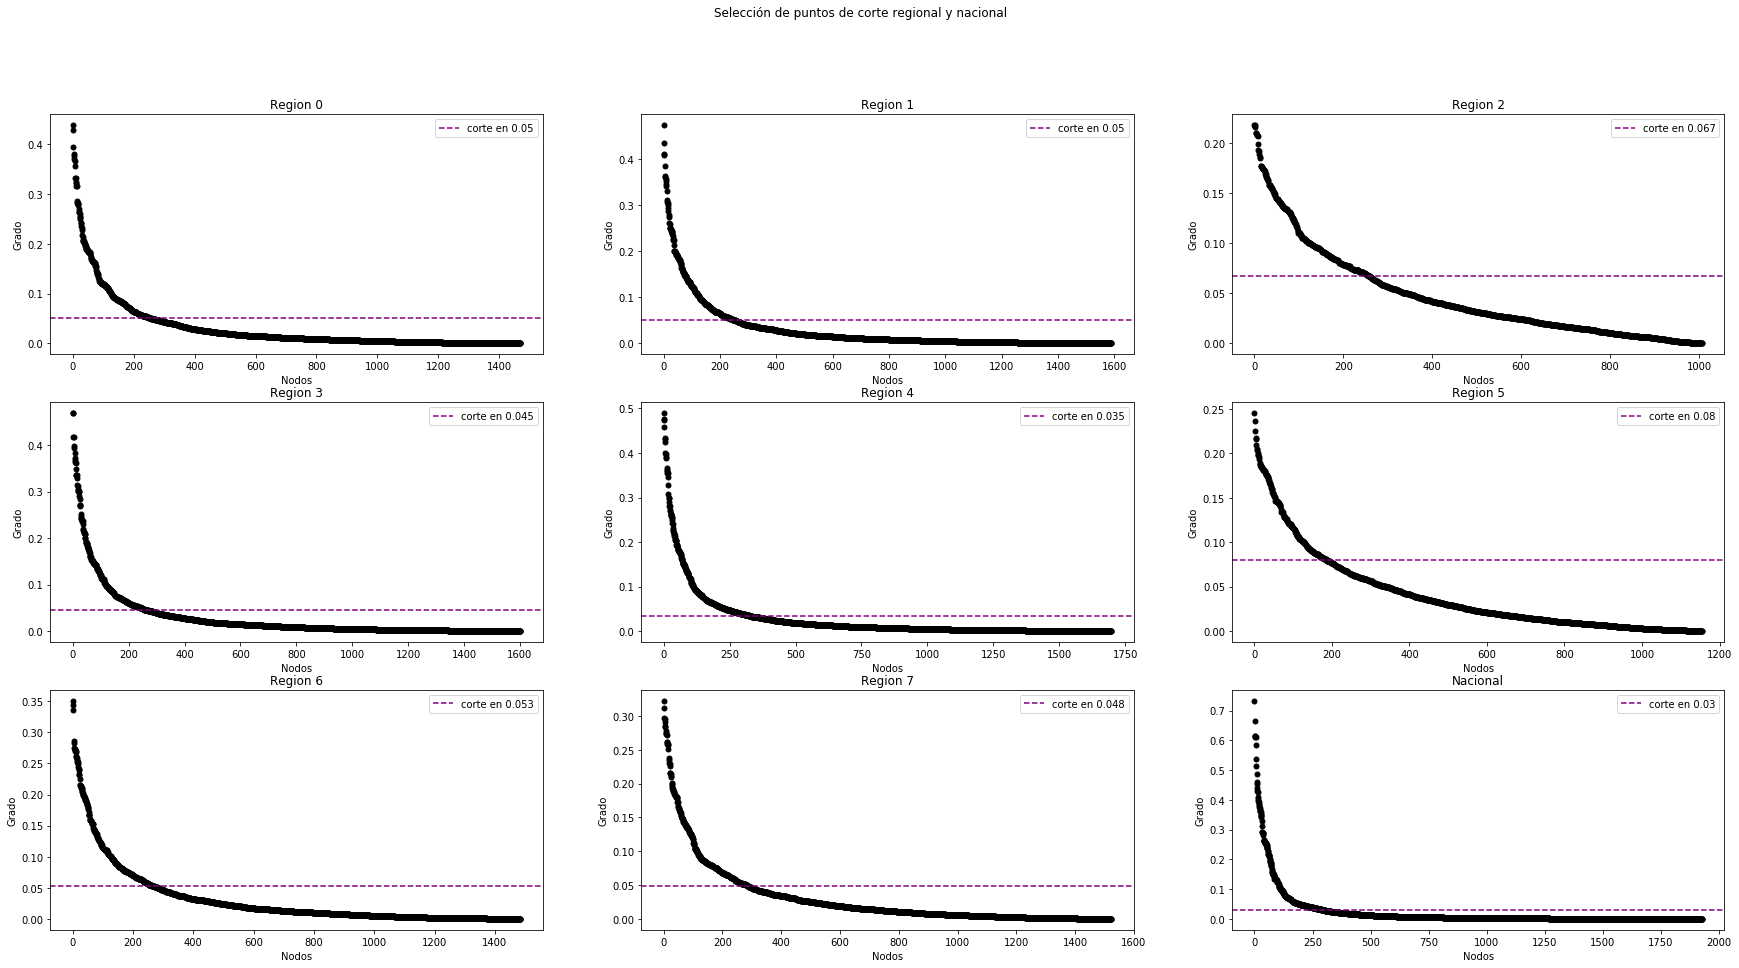

In [9]:
fig, axs = plt.subplots(3, 3, figsize=(30, 15))

for g in range(8):
    grados = sorted([i[2] for i in regiones[g].edges(data='weight')])
    axs[g//3, g%3].plot(grados[::-1], '.k', markersize=10)
    axs[g//3, g%3].axhline(y=cut_point[g], color='purple', ls='--', label=f'corte en {cut_point[g]}')
    axs[g//3, g%3].legend(loc='upper right')
    axs[g//3, g%3].set_title(f'Region {g}')
    axs[g//3, g%3].set(xlabel='Nodos', ylabel='Grado')
    

###NACIONAL###
#grafico el peso de las aristas
g = 8
grados = sorted([i[2] for i in G_2.edges(data='weight')])
axs[2, 2].plot(grados[::-1], '.k', markersize=10)
axs[2, 2].axhline(y=cut_point[g], color='purple', ls='--', label=f'corte en {cut_point[g]}')
axs[2, 2].legend(loc='upper right')
axs[2, 2].set_title(f'Nacional')
axs[2, 2].set(xlabel='Nodos', ylabel='Grado')

fig.suptitle('Selección de puntos de corte regional y nacional')
plt.show()

**Punto de corte**

|regiones | corte |
|:-------:|:-----:|
|0        |0.05   |
|1        |0.05   |
|2        |0.067  |
|3        |0.045  |
|4        |0.035  |
|5        |0.08   |
|6        |0.053  |
|7        |0.048  |
|nacional |0.03   |

## Volver a cargar grafo incluyendo el _cut point_

In [10]:
G_2 = nx.empty_graph(0, nx.DiGraph()) #initialize an empty weighted directed graph

In [11]:
for row in df.index:
    for col in df.columns:
        if not np.isnan(df.loc[row, col]) and (df.loc[row, col] >= cut_point[-1]):
            G_2.add_edge(row, col, weight=df.loc[row, col])

In [12]:
#inicializo lista de grafos vacios
regiones = [nx.empty_graph(0, nx.DiGraph()), nx.empty_graph(0, nx.DiGraph()), nx.empty_graph(0, nx.DiGraph()), nx.empty_graph(0, nx.DiGraph()),
          nx.empty_graph(0, nx.DiGraph()), nx.empty_graph(0, nx.DiGraph()), nx.empty_graph(0, nx.DiGraph()), nx.empty_graph(0, nx.DiGraph())]


In [13]:
for i in range(8):
    #cargo dataset
    pesos = pd.read_csv(f'data/pesos_reg_{i}.csv', index_col='Unnamed: 0', na_values=[np.nan, 0])
    
    #creo las aristas dirigidas pesadas del grafo
    for row in pesos.index:
        for col in pesos.columns:
            if not np.isnan(pesos.loc[row, col]) and pesos.loc[row, col] >= cut_point[i]:
                regiones[i].add_edge(row, col, weight=pesos.loc[row, col])

# Metricas

Un dataset por cada metrica (centralidades de grado, pagerank y betweenness de entrada y salida). En un principio son 4.

Dos variantes:
 - Cada columna es un dataset distinto (regiones y nacional siendo 8 en total) y cada fila es una variable de endireh.
 - Una función que me regrese el dataset con los primeros n mayores valores en la columnas pero con el nombre de la variable, no el valor.


## Pagerank

In [14]:
pagerank_values = pd.DataFrame(index=df.columns)
pagerank_sorted = pd.DataFrame()

In [15]:
pagerank_values['nacional'] = [nx.pagerank(G_2)[pr] for pr in df.columns] 
pagerank_sorted['nacional'] = [k for k,v in sorted(nx.pagerank(G_2).items(), key=lambda x: x[1], reverse=True)]

for g in range(8):
    pr_values = []
    for pr in df.columns:
        try:
            pr_values.append(nx.pagerank(regiones[g])[pr])
        except:
            pr_values.append(np.nan)
    pagerank_values[f'reg_{g}'] = pr_values
    
    pr_sorted = [k for k,v in sorted(nx.pagerank(regiones[g]).items(), key=lambda x: x[1], reverse=True)]
    pagerank_sorted[f'reg_{g}'] = pr_sorted
    
pagerank_values.to_csv(f'data/pagerank_values.csv')
pagerank_sorted.to_csv(f'data/pagerank_sorted.csv', index=False)

In [16]:
pagerank_sorted.head(10)

,nacional,reg_0,reg_1,reg_2,reg_3,reg_4,reg_5,reg_6,reg_7
0,P9_8_abuso,P9_8_abuso,P9_8_atencion,P9_8_atencion,P9_8_abuso,P9_8_abuso,P2_15,P9_8_abuso,P9_8_abuso
1,P9_8_atencion,P9_8_atencion,P9_8_abuso,P9_3,P9_8_atencion,P9_8_atencion,T_INSTRUM,P9_8_atencion,P9_8_atencion
2,ABORTO,PAREN,P9_7,P9_1,RES_MADRE,LENG_ESPAÑOL,P9_5,RES_MADRE,P1_4_9
3,NACIO_MUERT,RES_MADRE,P9_5,P9_7,PAREN,LENG_INDIGENA,P9_1,LENG_ESPAÑOL,ALFABETISMO
4,P9_3,T_INSTRUM,RES_MADRE,P2_15,T_INSTRUM,PERT_INDIGENA,P2_14,P1_4_1,P1_10_1
5,P9_7,RES_PADRE,P1_4_6,T_INSTRUM,RES_PADRE,P9_7,P9_7,NACIO_MUERT,ABORTO
6,LENG_ESPAÑOL,NACIO_MUERT,P9_1,DRENAJE,P9_3,ESTRATO,TRABAJO,LENG_INDIGENA,P1_4_4
7,P9_5,P9_3,PAREN,P2_14,P1_4_2,P9_5,P9_8_atencion,T_INSTRUM,PAREN
8,P1_4_6,EDAD,T_INSTRUM,TRABAJO,P9_7,P1_4_2,NACIO_MUERT,P9_7,LENG_ESPAÑOL
9,P9_1,P1_7,RES_PADRE,ESTRATO,P9_1,P9_1,ESCOLARIDAD,PERT_INDIGENA,ESTRATO


## Centralidad de grado

In [17]:
degree_centrality_values = pd.DataFrame(index=df.columns)
degree_centrality_sorted = pd.DataFrame()

In [18]:
degree_centrality_values['nacional'] = [nx.degree_centrality(G_2)[pr] for pr in df.columns]
degree_centrality_sorted['nacional'] = [k for k,v in sorted(nx.degree_centrality(G_2).items(), key=lambda x: x[1], reverse=True)]

for g in range(8):
    dc_values = []
    for dc in df.columns:
        try: 
            dc_values.append(nx.degree_centrality(regiones[g])[dc])
        except:
            dc_values.append(np.nan)
    degree_centrality_values[f'reg_{g}'] = dc_values
    
    dc_sorted = [k for k,v in sorted(nx.degree_centrality(regiones[g]).items(), key=lambda x: x[1], reverse=True)]
    degree_centrality_sorted[f'reg_{g}'] = dc_sorted
    
degree_centrality_values.to_csv(f'data/degree_centrality_values.csv')
degree_centrality_sorted.to_csv(f'data/degree_centrality_sorted.csv', index=False)

In [19]:
degree_centrality_sorted.head(10)

,nacional,reg_0,reg_1,reg_2,reg_3,reg_4,reg_5,reg_6,reg_7
0,ESTRATO,FOCOS,FOCOS,FOCOS,FOCOS,FOCOS,FOCOS,ESCOLARIDAD,FOCOS
1,FOCOS,ESCOLARIDAD,ESTRATO,P1_2_A,P1_7,ESCOLARIDAD,P1_2_A,FOCOS,ESCOLARIDAD
2,P1_7,P1_7,ESCOLARIDAD,P1_4_9,PISOS,ESTRATO,ESCOLARIDAD,ESTRATO,P1_2_A
3,ESCOLARIDAD,ESTRATO,P1_2,P9_1,P1_2_A,P1_2_A,ESTRATO,DRENAJE,ESTRATO
4,P1_4_3,EDAD,P1_7,ESCOLARIDAD,ESCOLARIDAD,EDAD,P1_4_7,EDAD,AGUA
5,P1_4_6,AGUA,AGUA,P1_2,ESTRATO,P1_4_7,P1_2,P1_7,PISOS
6,P1_4_7,P1_4_9,P1_2_A,P1_7,P1_2,P1_4_3,P1_7,P1_4_7,P9_1
7,AGUA,P1_2_A,EDAD,P1_4_8,EDAD,P1_7,DRENAJE,P1_4_5,P1_7
8,P1_2_A,DRENAJE,P1_4_7,P1_4_1,P1_4_7,P1_4_9,AGUA,P1_2,P1_4_6
9,P1_4_9,P1_2,P1_4_3,EDAD,P1_4_3,AGUA,P1_4_6,P1_2_A,PAREN


## Centralidad betweenness

In [20]:
betweenness_values = pd.DataFrame(index=df.columns)
betweenness_sorted = pd.DataFrame()

In [21]:
betweenness_values['nacional'] = [nx.betweenness_centrality(G_2)[pr] for pr in df.columns]
betweenness_sorted['nacional'] = [k for k,v in sorted(nx.betweenness_centrality(G_2).items(), key=lambda x: x[1], reverse=True)]

for g in range(8):
    bc_values = []
    for bc in df.columns:
        try:
            bc_values.append(nx.betweenness_centrality(regiones[g])[bc])
        except:
            bc_values.append(np.nan)
    betweenness_values[f'reg_{g}'] = bc_values
    
    bc_sorted = [k for k,v in sorted(nx.betweenness_centrality(regiones[g]).items(), key=lambda x: x[1], reverse=True)]
    betweenness_sorted[f'reg_{g}'] = bc_sorted
    
betweenness_values.to_csv(f'data/betweenness_values.csv')
betweenness_sorted.to_csv(f'data/betweenness_sorted.csv', index=False)

In [22]:
betweenness_sorted.head(10)

,nacional,reg_0,reg_1,reg_2,reg_3,reg_4,reg_5,reg_6,reg_7
0,P1_7,FOCOS,ESCOLARIDAD,P9_1,FOCOS,ESCOLARIDAD,ESTRATO,ESCOLARIDAD,P1_2
1,ESTRATO,ESCOLARIDAD,P1_2,ESCOLARIDAD,EDAD,ESTRATO,ESCOLARIDAD,EDAD,FOCOS
2,P1_2_A,P1_2,ESTRATO,P1_2_A,P1_7,EDAD,P1_4_7,P9_1,ESCOLARIDAD
3,ESCOLARIDAD,P1_7,EDAD,P1_7,ESCOLARIDAD,P9_1,FOCOS,FOCOS,ESTRATO
4,FOCOS,EDAD,FOCOS,EDAD,P9_1,P1_7,GRA,P1_4_7,P1_7
5,P9_1,P9_1,P1_7,P9_7,P1_2_A,P1_2_A,P1_2_A,PAREN,P9_1
6,P1_2,PAREN,P9_1,FOCOS,PAREN,FOCOS,EDAD,P1_2,PAREN
7,PISOS,GRA,P1_4_7,P1_4_9,PISOS,PERT_INDIGENA,P1_2,P1_7,P1_2_A
8,EDAD,P1_4_3,PAREN,NACIO_VIV,GRA,P1_2,DRENAJE,P1_4_6,P1_4_9
9,P1_4_6,P1_4_9,GRA,P1_4_8,P1_2,AGUA,AGUA,LENG_ESPAÑOL,EDAD


## Visualizar los grafos obtenidos

In [23]:
pos = nx.spring_layout(G_2, seed=5)
# la región 2 es la región con menos registros lo cual da una gráfica más limpia
# pero al graficarla con algunas regiones da error, por eso se elige la la región 5 que es la segunda región con menos registros

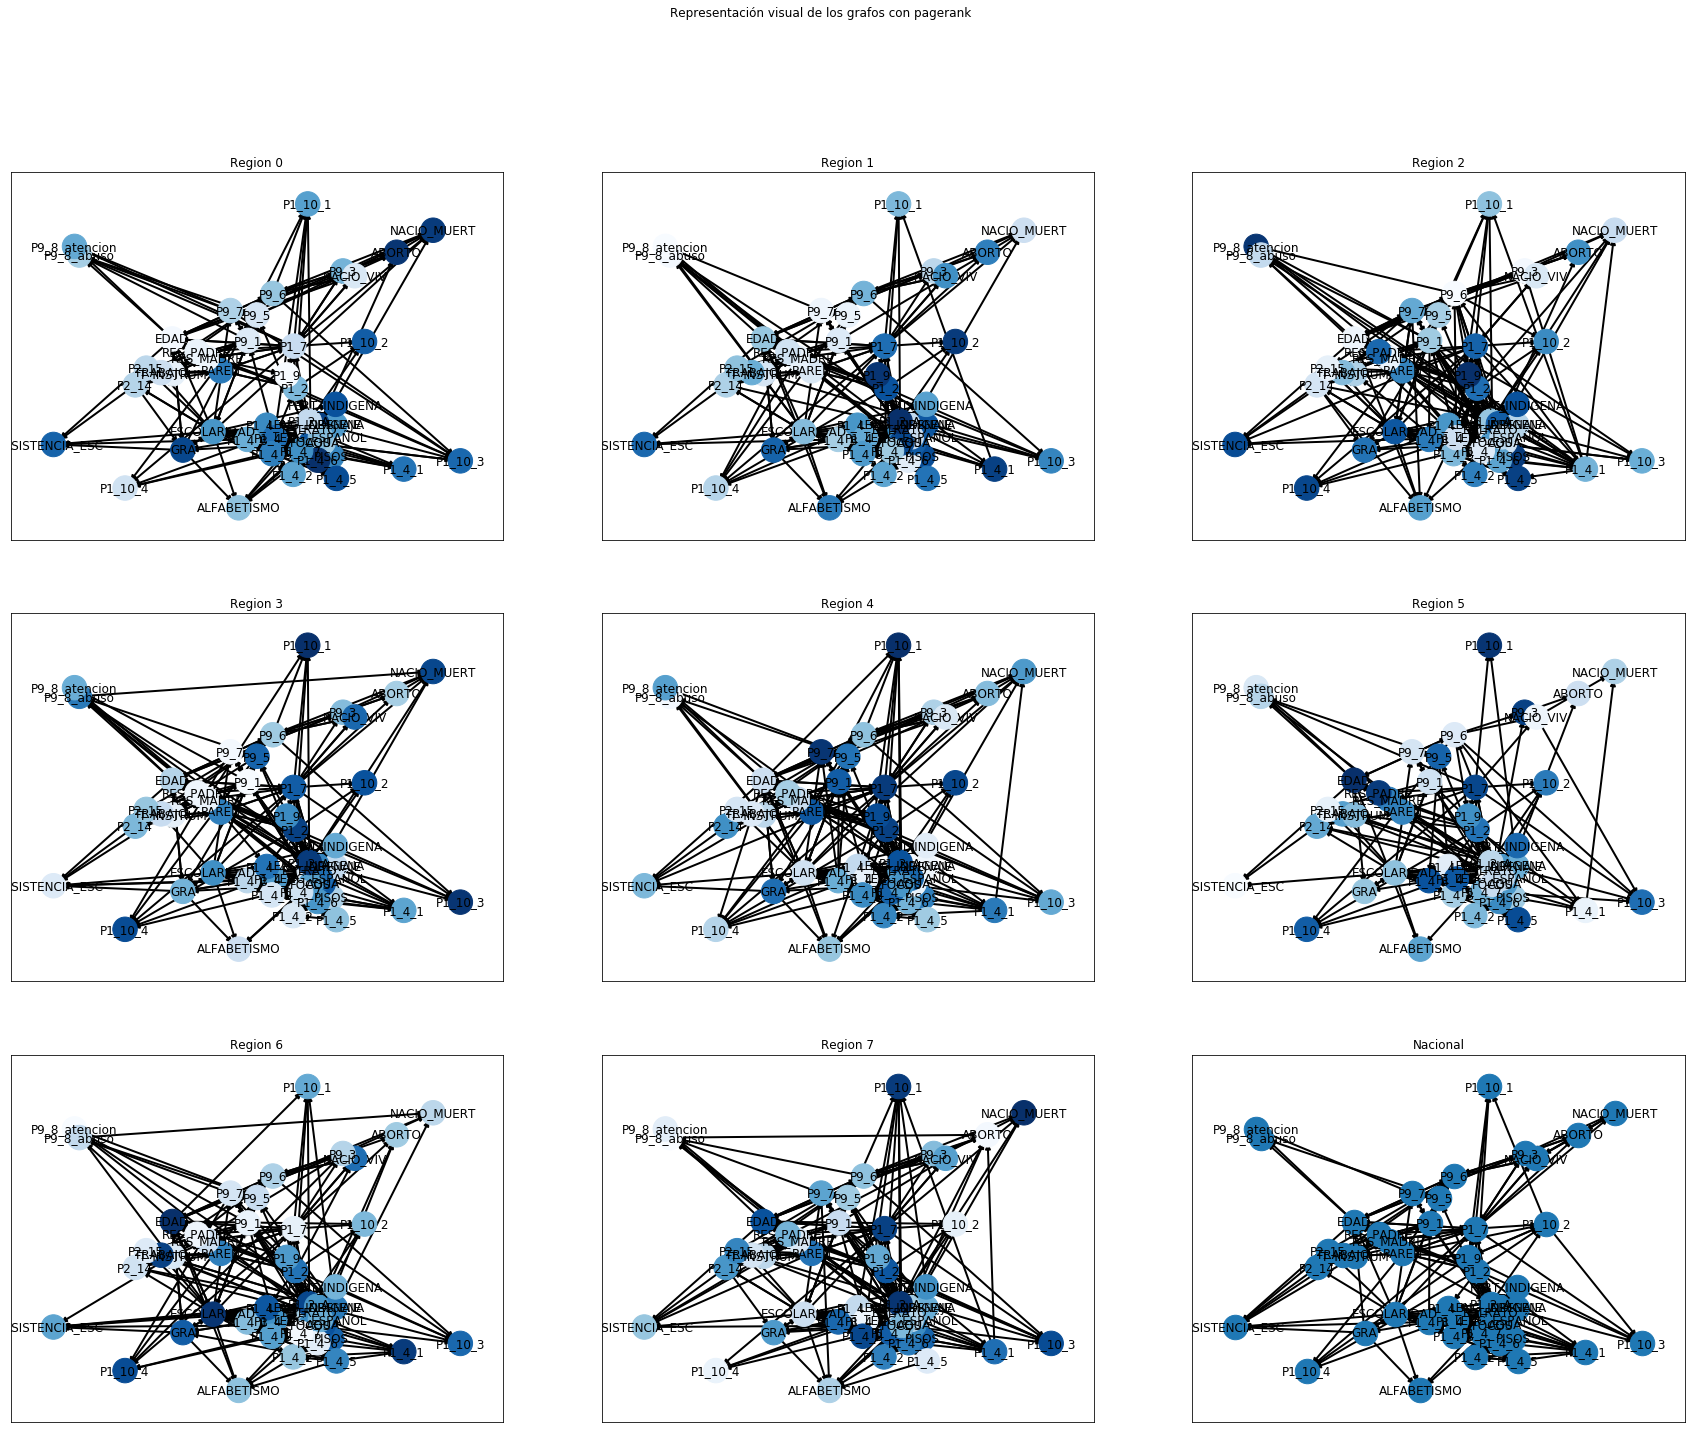

In [25]:
fig, axs = plt.subplots(3, 3, figsize=(30, 23))

for g in range(8):
    nx.draw_networkx_nodes( regiones[g], pos, node_size=600, cmap=plt.cm.Blues,
                           node_color=[pagerank_sorted.nacional[pagerank_sorted[f'reg_{g}']==col].index[0] for col in regiones[1].nodes], 
                           ax=axs[g//3, g%3])
    nx.draw_networkx_labels(regiones[g], pos, ax=axs[g//3, g%3])
    nx.draw_networkx_edges( regiones[g], pos, edgelist=regiones[g].edges(data='weight'), width=2, edge_color='k', ax=axs[g//3, g%3])
    axs[g//3, g%3].set_title(f'Region {g}')
    
###NACIONAL###
nx.draw_networkx_nodes(G_2, pos, node_size=600, ax=axs[2, 2])
nx.draw_networkx_labels(G_2, pos, ax=axs[2, 2])
nx.draw_networkx_edges(G_2, pos, edgelist=G_2.edges(data='weight'), width=2, edge_color='k', ax=axs[2, 2])
axs[2,2].set_title(f'Nacional')

fig.suptitle('Representación visual de los grafos con pagerank')
plt.show()

dejar más claro que entre mas claro el color, más importancia tiene

Comentar:
1. Incluí ESTRATO
    - ¿borrar preguntas P1?
2. La inconscistencia en rango de edades.
4. Hacer el experimento por dominio (urbano y rural)
5. Los proyectos:
    - Toma de decision
    - Administracion del conocimiento
6. 

# Pendientes
1. Revisar código para resolver que todos tengan el mismo grado **listo**
2. Por cada grafo obtener el histograma de grado o FI (preguntar) y elegir umbral a cortar. Todos los que esten arriba de ese umbral serán los que quedaran y los demás enlaces se borraran. **listo**
4. Obtener centralidades de grado, pagerank y betweness  y guardarlo en csv. Por region y nacional. **listo**
1. cambiar de multiDiGraph a DiGraph.  **listo**
3. una funcion que se le da un csv y me deja las mayores n centralidades con los nombres de columnas en valor. **listo**
2. codigo de color en los nodos basado en pagerank. **listo**
---
1. hacer los grafos de dominio.
1. revisar por qué no grafica LENG_ESP en el grafo.
4. comparar los grafos. (densidad, diametro, coeficiente de clustering) y pensar otras formas.
4. Comenzar a escribir la justificación del preprocesamiento y la descripción de los datos.


### Librerías compatibles
https://scikit-network.readthedocs.io/en/latest/